<a href="https://colab.research.google.com/github/bailejor/SAMSHA_Transfer_Learning/blob/main/General_sub_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image_dataset_from_directory
from keras.models import Model
from keras.optimizers import Adam, SGD
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical


In [ ]:
!unzip /content/drive/MyDrive/ValImages.nosync.zip

In [3]:
!unzip /content/drive/MyDrive/TrainImages_70.nosync.zip

Streaming output truncated to the last 5000 lines.
  inflating: TrainImages_70.nosync/Suc/SAMSHA129549.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA310364.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA252625.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA34133.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA406749.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA298892.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA272293.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA72166.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA289747.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA252143.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA286474.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA86781.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA310402.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA382160.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA140299.jpg  
  inflating: TrainImages_70.nosync/Suc/SAMSHA299554.jpg  
  inflating: TrainImages

Found 435974 files belonging to 2 classes.
Using 305182 files for training.
Found 435974 files belonging to 2 classes.
Using 130792 files for validation.
Found 93728 files belonging to 2 classes.


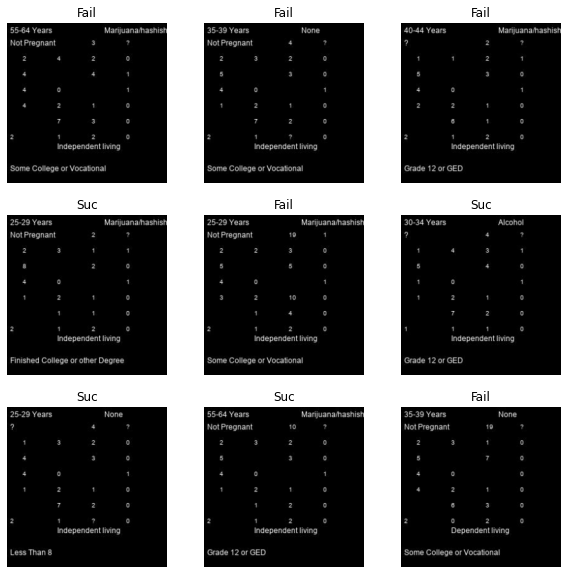

In [5]:



train_dataset = image_dataset_from_directory(
    '/content/TrainImages_70.nosync',
    validation_split=0.3,
    subset="training",
    seed=6,
    image_size=(250, 250),
    batch_size=32,
    shuffle = True,
    color_mode = 'rgb'
)

validation_dataset = image_dataset_from_directory(
    '/content/TrainImages_70.nosync',
    validation_split=0.3,
    subset="validation",
    seed=6,
    image_size=(250, 250),
    batch_size=32,
    shuffle = True,
    color_mode = 'rgb'
)




test_dataset = image_dataset_from_directory('/content/ValImages.nosync', image_size=(250, 250), color_mode='rgb', batch_size = 32,  shuffle=False)

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+ 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')


In [3]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
         ModelCheckpoint(filepath='/content/drive/MyDrive/best_model_transfer.h5', monitor='val_loss', save_best_only=True)]

input_t = keras.Input(shape=(250, 250, 3))
base_model = keras.applications.ResNet50(input_tensor=input_t, include_top=False, weights='imagenet') 
base_model.trainable = False



inputs = keras.Input(shape=(250, 250, 3))
x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.compile(loss = keras.losses.BinaryCrossentropy(from_logits=True), optimizer = keras.optimizers.Adam(),
              metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy(), keras.metrics.TruePositives(), keras.metrics.TrueNegatives(), keras.metrics.FalseNegatives(), keras.metrics.FalsePositives()])

class_weight = {0:30, 1:70}


model.fit(train_dataset, epochs = 15, verbose = 1, validation_data = validation_dataset, class_weight= class_weight, callbacks = callbacks)


Epoch 1/15
9537/9537 [==============================] - 1789s 187ms/step - loss: 27.7242 - auc: 0.6810 - binary_accuracy: 0.5692 - true_positives: 43203.2252 - true_negatives: 45710.8158 - false_negatives: 14668.5679 - false_positives: 49041.3873 - val_loss: 0.5920 - val_auc: 0.7366 - val_binary_accuracy: 0.6786 - val_true_positives: 31212.0000 - val_true_negatives: 57546.0000 - val_false_negatives: 18485.0000 - val_false_positives: 23549.0000
Epoch 2/15
9537/9537 [==============================] - 1581s 166ms/step - loss: 26.6682 - auc: 0.7191 - binary_accuracy: 0.6122 - true_positives: 42932.6854 - true_negatives: 50584.3689 - false_negatives: 14938.8562 - false_positives: 44168.0858 - val_loss: 0.6566 - val_auc: 0.7422 - val_binary_accuracy: 0.5921 - val_true_positives: 41141.0000 - val_true_negatives: 36306.0000 - val_false_negatives: 8556.0000 - val_false_positives: 44789.0000
Epoch 3/15
9537/9537 [==============================] - 1534s 161ms/step - loss: 26.4936 - auc: 0.7247 - 

In [6]:
np.set_printoptions(threshold=np.inf)

input_t = keras.Input(shape=(250, 250, 3))
base_model = keras.applications.ResNet50(input_tensor=input_t, include_top=False, weights='imagenet') 
base_model.trainable = False



inputs = keras.Input(shape=(250, 250, 3))
x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.load_weights('/content/drive/MyDrive/best_model_transfer.h5')

test_labels = []
test_classes = test_dataset.class_names
for images, labels in test_dataset:
  test_labels.append(labels)
test_labels = np.concatenate(test_labels, axis=0 )
test_labels = test_labels.flatten()



pred = model.predict(test_dataset)
pred[pred<0.5]=0
pred[pred>=0.5]=1

jor = pred.flatten()




print(balanced_accuracy_score(test_labels, jor))
print(roc_auc_score(test_labels, jor))
print(accuracy_score(test_labels, jor))
print(confusion_matrix(test_labels, jor))

94773248/94765736 [==============================] - 1s 0us/step
0.6262639986877989
0.6262639986877988
0.703653123933083
[[55123  3000]
 [24776 10829]]
